# Selecting Data

This notebook shows how to select data in `dysh`.  By selecting data, you can narrow down which scans or integrations the calibration routines will operate on. We call such narrowing down  a "selection rule."   You create selection rules through methods of  [GBTFITSLoad](https://dysh.readthedocs.io/en/latest/reference/modules/dysh.fits.html#module-dysh.fits.gbtfitsload.GBTFITSLoad), which uses an instance of [Selection](https://dysh.readthedocs.io/en/latest/reference/modules/dysh.util.html#dysh.util.selection.Selection) as an attribute called `selection`.  You can create multiple selection rules that will be logically ANDed to create a final rule at calibration time.

## Loading Modules
We start by loading the modules we will use in this tutorial. 

In [1]:
# These modules are required for the tutorial.
import astropy.units as u
from astropy.time import Time
from dysh.fits.gbtfitsload import GBTFITSLoad

# These modules are only used to download the data.
from pathlib import Path
from dysh.util.download import from_url

## Data Retrieval

Download the example SDFITS data, if necessary.

The code below will download an SDFITS file from http://www.gb.nrao.edu/dysh/example_data and put it in a data directory.
The data directory must exist where this notebook is being run from, otherwise the downloaded SDFITS will be named data.
The example will work either way, but be aware if you find a new file named data after running it.

In [2]:
url = "http://www.gb.nrao.edu/dysh/example_data/hi-survey/data/AGBT04A_008_02.raw.acs/AGBT04A_008_02.raw.acs.fits"
savepath = Path.cwd() / "data"
savepath.mkdir(exist_ok=True) # Create the data directory if it does not exist.
filename = from_url(url, savepath)

## Data Loading

Next, we use `GBTFITSLoad` to load the data, and then its `summary` method to inspect its contents.

In [3]:
sdfits = GBTFITSLoad(filename)
sdfits.summary(add_columns=["UTC"])

SCAN,OBJECT,VELOCITY,PROC,PROCSEQN,RESTFREQ,DOPFREQ,# IF,# POL,# INT,# FEED,AZIMUTH,ELEVATION,UTC
220,3C286,0.0,OffOn,1,1.400000,1.400000,1,2,6,1,185.2806,82.0246,2004-04-22 04:51:41.035000192
221,3C286,0.0,OffOn,2,1.400000,1.400000,1,2,6,1,187.2136,81.9980,2004-04-22 04:52:56.034999936
222,3C286,0.0,OffOn,1,1.400000,1.400000,1,2,6,1,193.8331,81.8413,2004-04-22 04:57:18.034999936
223,3C286,0.0,OffOn,2,1.400000,1.400000,1,2,6,1,195.6766,81.7788,2004-04-22 04:58:33.035000192
224,3C286,0.0,OffOn,1,1.400000,1.400000,1,2,6,1,195.5182,80.2910,2004-04-22 05:00:06.034999936
225,3C286,0.0,OffOn,2,1.400000,1.400000,1,2,5,1,199.9358,81.6005,2004-04-22 05:01:31.028000128
226,3C286,0.0,OffOn,1,1.400000,1.400000,1,2,6,1,200.8333,80.0265,2004-04-22 05:04:25.035000192
227,3C286,0.0,OffOn,2,1.400000,1.400000,1,2,6,1,205.9471,81.2609,2004-04-22 05:05:57.035000192
228,B1328+254,0.0,OffOn,1,1.400000,1.400000,1,2,6,1,207.5257,73.9844,2004-04-22 05:17:26.034999936
229,B1328+254,0.0,OffOn,2,1.400000,1.400000,1,2,6,1,210.9600,75.1584,2004-04-22 05:18:54.034999936


## Using Selection

Now we show various ways in `GBTFITSLoad's` `Selection` object can be used to select data.

### Select by column value

One way of selecting data is by specifying a value for an SDFITS column name. (The column name case insensitive, but the value is not). 
For example, we can select data which has OBJECT="U8249" or OBJECT="U8249" using the following.

**Note** Selecting values in a list will logically OR those values.  So `object=["U8249","U11017"]` will select scans with either object.  But multiple keywords (columns) will be logically ANDed (see below).

In [6]:
sdfits.select(object=["U8249","U11017"])

We can view the contents of the selection using its `show` method.
This displays the selection as a table.  The `# Selected` column gives the number of records (integrations) selected by each. selection rule. Each time we create a new selection, it is assigned a unique id and tag. 


In [51]:
sdfits.selection.show()

 ID    TAG     ... # SELECTED
--- ---------- ... ----------
  0 time range ...        216


We can also specify the tag name to have a more meaningful value. 

In [8]:
sdfits.select(proc="OffOn", tag='proc onoff')

In [9]:
sdfits.selection.show()

 ID    TAG           OBJECT        PROC # SELECTED
--- ---------- ------------------ ----- ----------
  0  b4cb8dba1 ['U8249','U11017']              572
  1 proc onoff                    OffOn       3540


### Combining Selections

Once we have multiple selection rules in the`Selection` object, we can combine them into a single selection using the `final` property. 
This will return a [pandas DataFrame](http://whatever).

In [10]:
sdfits.selection.final

,OBJECT,BANDWID,DATE-OBS,DURATION,EXPOSURE,TSYS,TDIM7,TUNIT7,CTYPE1,CRVAL1,...,SITELAT,SITEELEV,EXTNAME,FITSINDEX,UTC,CHAN,PROC,OBSTYPE,SUBOBSMODE,INTNUM
0,U8249,12500000.0,2004-04-22T06:44:49.00,5.005,4.779488,1.0,"(32768,1,1,1)",Counts,FREQ-OBS,1.408421e+09,...,38.43312,824.595,SINGLE DISH,0,2004-04-22 06:44:49.000,None,OffOn,PSWITCHOFF,TPWCAL,0
1,U8249,12500000.0,2004-04-22T06:44:49.00,5.005,4.779488,1.0,"(32768,1,1,1)",Counts,FREQ-OBS,1.408421e+09,...,38.43312,824.595,SINGLE DISH,0,2004-04-22 06:44:49.000,None,OffOn,PSWITCHOFF,TPWCAL,0
2,U8249,12500000.0,2004-04-22T06:44:49.00,5.005,4.779488,1.0,"(32768,1,1,1)",Counts,FREQ-OBS,1.408421e+09,...,38.43312,824.595,SINGLE DISH,0,2004-04-22 06:44:49.000,None,OffOn,PSWITCHOFF,TPWCAL,0
3,U8249,12500000.0,2004-04-22T06:44:49.00,5.005,4.779488,1.0,"(32768,1,1,1)",Counts,FREQ-OBS,1.408421e+09,...,38.43312,824.595,SINGLE DISH,0,2004-04-22 06:44:49.000,None,OffOn,PSWITCHOFF,TPWCAL,0
4,U8249,12500000.0,2004-04-22T06:44:59.01,5.005,4.779488,1.0,"(32768,1,1,1)",Counts,FREQ-OBS,1.408421e+09,...,38.43312,824.595,SINGLE DISH,0,2004-04-22 06:44:59.010,None,OffOn,PSWITCHOFF,TPWCAL,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
515,U11017,12500000.0,2004-04-22T10:12:48.02,10.000,9.596709,1.0,"(32768,1,1,1)",Counts,FREQ-OBS,1.398806e+09,...,38.43312,824.595,SINGLE DISH,0,2004-04-22 10:12:48.020,None,OffOn,PSWITCHON,TPNOCAL,27
516,U11017,12500000.0,2004-04-22T10:12:58.02,10.000,9.596709,1.0,"(32768,1,1,1)",Counts,FREQ-OBS,1.398806e+09,...,38.43312,824.595,SINGLE DISH,0,2004-04-22 10:12:58.020,None,OffOn,PSWITCHON,TPNOCAL,28
517,U11017,12500000.0,2004-04-22T10:12:58.02,10.000,9.596709,1.0,"(32768,1,1,1)",Counts,FREQ-OBS,1.398806e+09,...,38.43312,824.595,SINGLE DISH,0,2004-04-22 10:12:58.020,None,OffOn,PSWITCHON,TPNOCAL,28
518,U11017,12500000.0,2004-04-22T10:13:08.02,10.000,9.596709,1.0,"(32768,1,1,1)",Counts,FREQ-OBS,1.398806e+09,...,38.43312,824.595,SINGLE DISH,0,2004-04-22 10:13:08.020,None,OffOn,PSWITCHON,TPNOCAL,29


In this particular case, we wind up with 520 integrations. This is a selection of objects U8249 or U11017 AND proc OnOff. Because keywords in the same selection rule are logically ANDed, this could also have been accomplished via

`sdfits.select(object=["U8249","U11017"], proc="OnOff")`

(Try it yourself).

### You can also see a summary of the selected data

In [11]:
sdfits.summary(selected=True)

SCAN,OBJECT,VELOCITY,PROC,PROCSEQN,RESTFREQ,DOPFREQ,# IF,# POL,# INT,# FEED,AZIMUTH,ELEVATION
266,U8249,2541.0,OffOn,1,1.420405,1.420405,1,2,10,1,241.7065,50.2801
267,U8249,2541.0,OffOn,1,1.420405,1.420405,1,2,30,1,242.6892,49.6343
268,U8249,2541.0,OffOn,2,1.420405,1.420405,1,2,30,1,242.5451,49.7333
275,U8249,2541.0,OffOn,1,1.420405,1.420405,1,2,30,1,266.5469,46.8377
276,U8249,2541.0,OffOn,2,1.420405,1.420405,1,2,30,1,266.3738,47.0388
300,U11017,4644.0,OffOn,1,1.420405,1.420405,1,2,30,1,235.4605,76.2074
301,U11017,4644.0,OffOn,2,1.420405,1.420405,1,2,30,1,234.7726,76.3879
302,U11017,4644.0,OffOn,1,1.420405,1.420405,1,2,30,1,241.5197,74.3514
303,U11017,4644.0,OffOn,2,1.420405,1.420405,1,2,30,1,240.9590,74.5471


### Remove selection rules
You can remove a selection rule by `id` or `tag`.
Multiple rows with the same tag will all be removed.

In [12]:
sdfits.selection.remove(id=0)
sdfits.selection.show()

 ID    TAG      PROC # SELECTED
--- ---------- ----- ----------
  1 proc onoff OffOn       3540


To remove all selection rules use `clear_selection`.  It will show no selection rules.

In [13]:
sdfits.clear_selection()
sdfits.selection.show()

 ID TAG OBJECT BANDWID DATE-OBS ... SUBOBSMODE FITSINDEX CHAN UTC # SELECTED
--- --- ------ ------- -------- ... ---------- --------- ---- --- ----------


### Select by Range

It is also possible to define a selection given a range of values.
In this case the selection must be specified using either a list, `[]`, or a tuple, `()`, with a start and an end value. Ranges are considered inclusive of both ends.
Lower limits are give by `(value,None)` or `(value,)`.
Upper limits are given by `(None,value)`, since `(,value)` is not valid `python`.
For coordinates the default unit is taken to be degrees.
Other units can be explicitly given.
Both `()` and `[]` are valid for indicated ranges, but only tuples can be   lower limit `(value,)`.

For example to select only rows where the right ascension is greater than 114 degrees:

In [14]:
sdfits.select_range(ra=(114,), tag="RA>=114 deg")
sdfits.selection.show()

 ID     TAG            CRVAL2       # SELECTED
--- ----------- ------------------- ----------
  0 RA>=114 deg [np.float64(114.0)]       3766


(Right Ascension is the FITS CRVAL2 column). To select rows where the elevation is below 80 degrees:

In [15]:
sdfits.select_range(elevation=[None,80], tag="EL<80")
sdfits.selection.show()

 ID     TAG            CRVAL2        ELEVATIO # SELECTED
--- ----------- ------------------- --------- ----------
  0 RA>=114 deg [np.float64(114.0)]                 3766
  1       EL<80                     [None,80]       3582


We can check that the selections were applied properly by inspecting the final result and a subset of its columns. (Note elevation column is ELEVATIO because the FITS standard only allow 8 characters for column names).

In [16]:
sdfits.selection.final[["OBJECT","CRVAL2","ELEVATIO"]]

,OBJECT,CRVAL2,ELEVATIO
0,3C286,202.784508,79.997019
1,3C286,202.784508,79.997019
2,3C286,202.784508,79.997019
3,3C286,202.784508,79.997019
4,B1328+254,202.066324,74.023075
...,...,...,...
3577,U11992,335.197517,55.157387
3578,U11992,335.197520,55.183819
3579,U11992,335.197520,55.183819
3580,U11992,335.197546,55.210211


It is also possible to use units during selection.
For example

In [17]:
sdfits.select_range(dec=[854, 855] * u.arcmin, tag="14.23<=DEC<=14.25")
sdfits.selection.show()

 ID        TAG               CRVAL2       ...  ELEVATIO # SELECTED
--- ----------------- ------------------- ... --------- ----------
  0       RA>=114 deg [np.float64(114.0)] ...                 3766
  1             EL<80                     ... [None,80]       3582
  2 14.23<=DEC<=14.25                     ...                  132


In [18]:
sdfits.summary(selected=True)

SCAN,OBJECT,VELOCITY,PROC,PROCSEQN,RESTFREQ,DOPFREQ,# IF,# POL,# INT,# FEED,AZIMUTH,ELEVATION
321,U11992,3592.0,Track,1,1.420405,1.420405,1,2,3,1,124.4762,54.3242
322,U11992,3592.0,OffOn,1,1.420405,1.420405,1,2,30,1,125.6320,54.9128
323,U11992,3592.0,OffOn,2,1.420405,1.420405,1,2,30,1,125.4565,54.8251


### Select Within a Range

It is also possible to specify the midpoint and a range to make a selection.
In this case we use `select_within` and specify the mean value and the +- range.

For example to select between elevation of 50-10 and 50+10 we would use

In [19]:
sdfits.select_within(elevation=(50,10),tag="EL=50+/-10")
sdfits.selection.show()

 ID        TAG               CRVAL2       ...  ELEVATIO # SELECTED
--- ----------------- ------------------- ... --------- ----------
  0       RA>=114 deg [np.float64(114.0)] ...                 3766
  1             EL<80                     ... [None,80]       3582
  2 14.23<=DEC<=14.25                     ...                  132
  3        EL=50+/-10                     ...   [40,60]       1694


Which shows a selection between 40 and 60 degrees of elevation.

### Now, when you do a `getps` it will operate only on the selected data. 
(Currently, you can't preselect ifnum, plnum, or fdnum; they must be provided as method arguments).

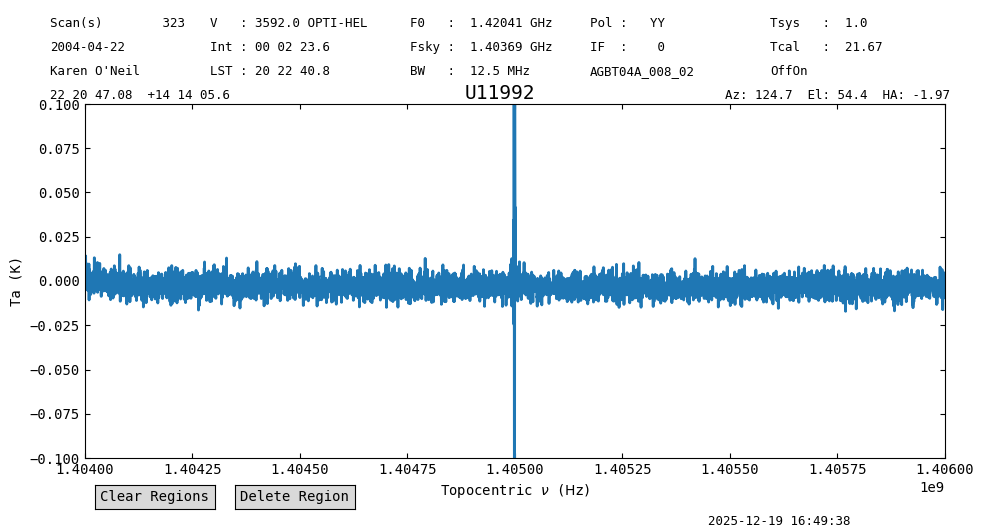

In [20]:
sb=sdfits.getps(ifnum=0,plnum=0,fdnum=0)
sb.timeaverage().plot(ymin=-.1,ymax=.1, xmin=1.404E9,xmax=1.406E9)

### Using Aliases

`Selection` knows about certain aliases for column names.
For example, the SDFITS column ELEVATIO can also be selected using ELEVATION.
The aliases are defined in the `aliases` attribute of `Selection`.

In [21]:
sdfits.selection.aliases

{'FREQ': 'CRVAL1',
 'RA': 'CRVAL2',
 'DEC': 'CRVAL3',
 'GLON': 'CRVAL2',
 'GLAT': 'CRVAL3',
 'GALLON': 'CRVAL2',
 'GALLAT': 'CRVAL3',
 'ELEVATION': 'ELEVATIO',
 'SOURCE': 'OBJECT',
 'POL': 'PLNUM',
 'SUBREF': 'SUBREF_STATE'}

It is also possible to add your own aliases.
For example to use target and az as aliases for OBJECT and AZIMUTH we would use

In [22]:
sdfits.selection.alias({'target':'object','az':'azimuth'})
sdfits.selection.aliases

{'FREQ': 'CRVAL1',
 'RA': 'CRVAL2',
 'DEC': 'CRVAL3',
 'GLON': 'CRVAL2',
 'GLAT': 'CRVAL3',
 'GALLON': 'CRVAL2',
 'GALLAT': 'CRVAL3',
 'ELEVATION': 'ELEVATIO',
 'SOURCE': 'OBJECT',
 'POL': 'PLNUM',
 'SUBREF': 'SUBREF_STATE',
 'TARGET': 'OBJECT',
 'AZ': 'AZIMUTH'}

### Then you can select using your aliases

In [23]:
sdfits.select(target="U8249")
sdfits.selection.show()

 ID        TAG        OBJECT ...  ELEVATIO # SELECTED
--- ----------------- ------ ... --------- ----------
  0       RA>=114 deg        ...                 3766
  1             EL<80        ... [None,80]       3582
  2 14.23<=DEC<=14.25        ...                  132
  3        EL=50+/-10        ...   [40,60]       1694
  4         3abb7a818  U8249 ...                  304


Notice that this will only affect the aliases for this particular instance of a `GBTFITSLoad`.
Any new `GBTFITSLoad` objects will not know about these aliases.

### Empty Selections

Any selection that results in no data being selected is ignored.
You will get a warning message in this case.

In [24]:
sdfits.selection.select(target='foobar')
sdfits.selection.show()

 ID        TAG        OBJECT ...  ELEVATIO # SELECTED
--- ----------------- ------ ... --------- ----------
  0       RA>=114 deg        ...                 3766
  1             EL<80        ... [None,80]       3582
  2 14.23<=DEC<=14.25        ...                  132
  3        EL=50+/-10        ...   [40,60]       1694
  4         3abb7a818  U8249 ...                  304


### Time Selections

UTC time ranges can be selected with Time objects.
This checks against the UTC timestamp column.
For LST, use select_range(lst=[number1,number2]).



In [68]:
# clear the selection for this demonstration
sdfits.clear_selection()

In [70]:
sdfits.select_range(utc=(Time("2004-04-22T05:27:20.12", scale="utc"),
                         Time("2004-04-22T05:48:43.12", scale="utc")),
                    tag="time range")
sdfits.selection.show()

 ID    TAG     ... # SELECTED
--- ---------- ... ----------
  0 time range ...        216


In [72]:
sdfits.selection.final[["SCAN","OBJECT","UTC", "LST","PLNUM","IFNUM","FDNUM"]]

,SCAN,OBJECT,UTC,LST,PLNUM,IFNUM,FDNUM
0,230,B1345+125,2004-04-22 05:27:25.130,51035.015413,1,0,0
1,230,B1345+125,2004-04-22 05:27:25.130,51035.015413,1,0,0
2,230,B1345+125,2004-04-22 05:27:25.130,51035.015413,0,0,0
3,230,B1345+125,2004-04-22 05:27:25.130,51035.015413,0,0,0
4,230,B1345+125,2004-04-22 05:27:35.140,51045.056730,1,0,0
...,...,...,...,...,...,...,...
211,245,B1345+125,2004-04-22 05:48:28.100,52301.445514,0,0,0
212,245,B1345+125,2004-04-22 05:48:38.110,52311.486833,1,0,0
213,245,B1345+125,2004-04-22 05:48:38.110,52311.486833,1,0,0
214,245,B1345+125,2004-04-22 05:48:38.110,52311.486833,0,0,0


### Channel Selection

You can selection a contiguous range of channels and the integrations will be trimmed to that channel range during calibration. The final spectrum will have the input channel range.  As with `select_range`, channel ranges are inclusive at both ends.

In [73]:
sdfits.select_channel([2000,6000], tag="channels")


In [74]:
sdfits.selection.show()

 ID    TAG     ... # SELECTED
--- ---------- ... ----------
  0 time range ...        216
  1   channels ...       3766


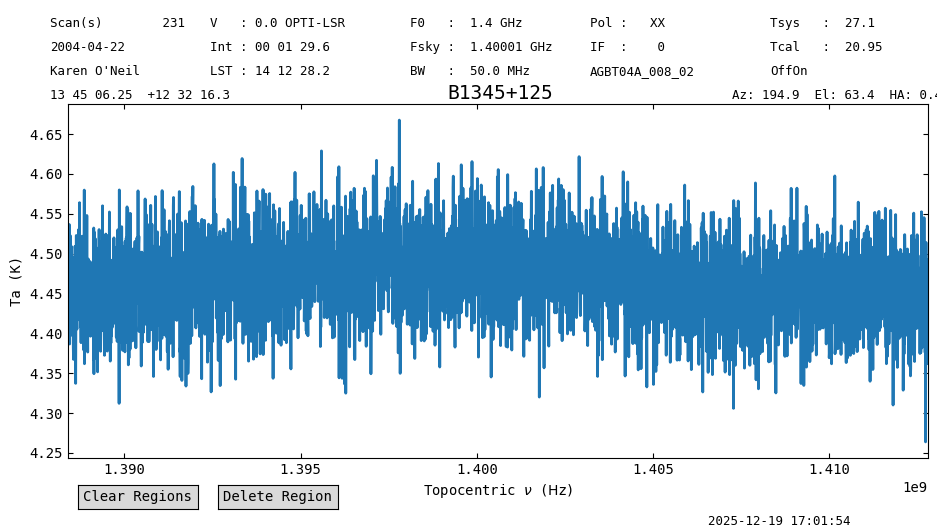

In [77]:
sb=sdfits.getps(ifnum=0,plnum=1,fdnum=0)
sb.timeaverage().plot()

### Note that you can only have one channel selection rule at a time.

In [78]:
try: 
    sdfits.select_channel([60,70])
except Exception as e:
    print(e)

You can only have one channel selection rule. Remove the old rule before creating a new one.
